Epoch 1/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 11826845712384.0000 - val_loss: 11788079857664.0000
Epoch 2/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11757107019776.0000 - val_loss: 11606986588160.0000
Epoch 3/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11514435076096.0000 - val_loss: 11118237974528.0000
Epoch 4/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10908314107904.0000 - val_loss: 10083998105600.0000
Epoch 5/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9697658667008.0000 - val_loss: 8287161417728.0000
Epoch 6/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7699093782528.0000 - val_loss: 5720128356352.0000
Epoch 7/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5003836653568.0000 - val_loss: 2846133059584.0000
Epoch 8/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2223053996032.0000 - val_loss: 683739381760.0000
Epoch 9/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 414156193792.0000 - val_loss: 6772864512.0000
Epoch 1

2025-05-22 05:45:06.617986: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30400000 exceeds 10% of free system memory.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/tmp/ipykernel_175749/1216178577.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(k, 'D_score'))


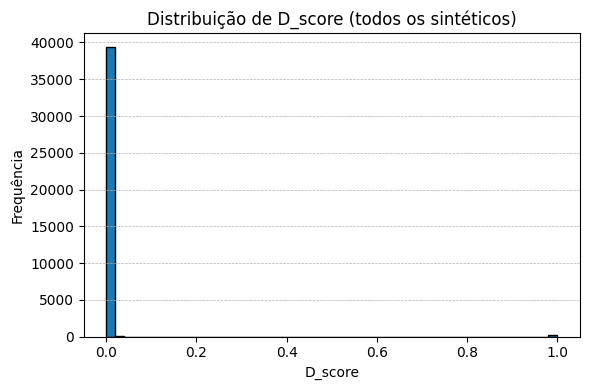

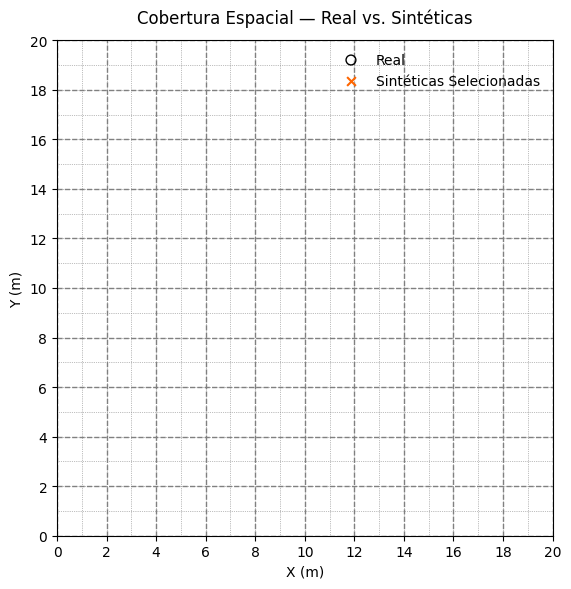

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. Carregar dados reais (B1–F2) e sintéticos gerados na Fase 2
# --------------------------------------------------
# 1.1) Real
df_full = pd.read_csv("/home/darkcover/Documentos/Gan/Data/Real/trainingData.csv")
wap_cols = [c for c in df_full.columns if c.startswith("WAP")]
df_full[wap_cols] = df_full[wap_cols].replace(100, -110)
df_real = df_full[(df_full.BUILDINGID==1)&(df_full.FLOOR==2)].copy()
present_waps = [c for c in wap_cols if (df_real[c] != -110).any()]  # ~190 WAPs :contentReference[oaicite:1]{index=1}
df_real = df_real[present_waps + ["LONGITUDE","LATITUDE"]]
df_real.rename(columns={"LONGITUDE":"X","LATITUDE":"Y"}, inplace=True)

# 1.2) Sintéticos
df_gen = pd.read_csv("/home/darkcover/Documentos/Gan/Data/df_generated_UJIndoorLoc.csv")   # 40 000×190 RSSI :contentReference[oaicite:3]{index=3}

# --------------------------------------------------
# 2. Treinar modelo DNN para pseudo-rotulação
# --------------------------------------------------
X_real = df_real[present_waps].values.astype(np.float32)
y_real = df_real[["X","Y"]].values.astype(np.float32)

inp = Input(shape=(len(present_waps),))
x   = Dense(30, activation="relu")(inp)
x   = Dense(20, activation="relu")(x)
out = Dense(2, activation="linear")(x)
model_dnn = Model(inp, out, name="PseudoLabel_UJ")
model_dnn.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss="mse")

model_dnn.fit(
    X_real, y_real,
    epochs=250, batch_size=100,
    validation_split=0.2, verbose=1
)
model_dnn.save("/home/darkcover/Documentos/Gan/Models/pseudo_label_model_UJ.keras")                    #:contentReference[oaicite:5]{index=5}

# --------------------------------------------------
# 3. Predição de (X,Y) e D_score
# --------------------------------------------------
X_gen = df_gen[present_waps].values.astype(np.float32)
coords = model_dnn.predict(X_gen, verbose=1)
df_gen[["X","Y"]] = coords

disc = load_model("/home/darkcover/Documentos/Gan/Models/discriminator_phase2_UJ.keras")    
d_scores = disc.predict(X_gen, verbose=1).flatten()
df_gen["D_score"] = d_scores

# salvar com coordenadas + confiança
df_gen.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated_with_coords.csv", index=False)

# --------------------------------------------------
# 4. Seleção Inteligente (1 000 amostras = 10×10 zonas de 2 m)
# --------------------------------------------------
L, W = 20.0, 20.0
zone_size = 2.0
nx, ny = int(L/zone_size), int(W/zone_size)
num_zones = nx*ny
k = 1000 // num_zones  # 10 por zona

# atribuir zona
df_gen['zone_x'] = np.minimum((df_gen['X']//zone_size).astype(int), nx-1)
df_gen['zone_y'] = np.minimum((df_gen['Y']//zone_size).astype(int), ny-1)
df_gen['zone_id'] = df_gen['zone_x']*ny + df_gen['zone_y']

# top-k por zona
selected = (
    df_gen
    .groupby('zone_id', as_index=False)
    .apply(lambda g: g.nlargest(k, 'D_score'))
    .reset_index(drop=True)
)
selected.to_csv("/home/darkcover/Documentos/Gan/Data/df_selected_synthetic.csv", index=False)


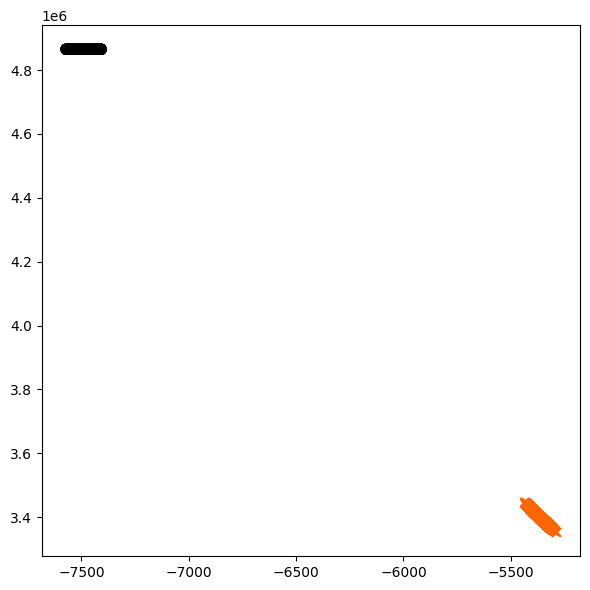

In [10]:

# --------------------------------------------------
# 5. Visualizações finais
# --------------------------------------------------
# 5.1) Cobertura espacial (Figura 6 estilo artigo)
fig, ax = plt.subplots(figsize=(6,6))
# reais: círculos vazados
ax.scatter(df_real['X'], df_real['Y'],
           facecolors='none', edgecolors='black', s=50, label='Real')
# sintéticos: xis laranja
ax.scatter(selected['X'], selected['Y'],
           marker='x', c='#FF6600', s=40, label='Sintéticas Selecionadas')
# grid 1 m fino
#for c in np.arange(0, L+1, 1):
#    ax.axvline(c, linestyle=':', linewidth=0.5, color='gray', zorder=0)
#    ax.axhline(c, linestyle=':', linewidth=0.5, color='gray', zorder=0)
# delimitações 2 m zonas
#for c in np.arange(0, L+zone_size, zone_size):
#    ax.axvline(c, linestyle='--', linewidth=1, color='gray', zorder=0)
#    ax.axhline(c, linestyle='--', linewidth=1, color='gray', zorder=0)
#ax.set_xlim(0, L); ax.set_ylim(0, W)
#ax.set_aspect('equal', 'box')
#ax.set_xticks(np.arange(0, L+1, 2))
#ax.set_yticks(np.arange(0, W+1, 2))
#ax.set_xlabel("X (m)"); ax.set_ylabel("Y (m)")
#ax.legend(frameon=False, loc='upper right')
#ax.set_title("Cobertura Espacial — Real vs. Sintéticas", pad=12)
plt.tight_layout()
plt.show()
